In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape
# There are 70,000 images, and each image has 784 features. because each image is 28×28 pixels
# each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

(70000, 784)

In [5]:
y.shape

(70000,)

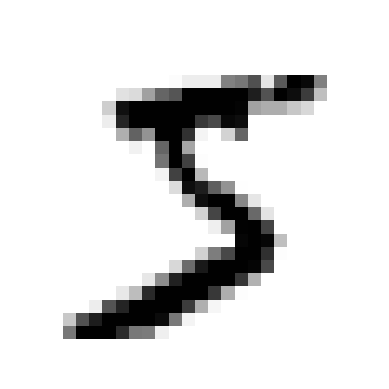

In [6]:
# To view a digit
#   - grab instance's feature vector and reshape it to 28*28 array
#   - display it using Matplotlib's imshow() function


import matplotlib as mpl
import matplotlib.pyplot as plt

# Correctly access the first row of the DataFrame
some_digit = X.iloc[0].values  # Ensure it is a numpy array for reshaping
some_digit_image = some_digit.reshape(28, 28)

# Display the image
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# THE CODE BELOW GIVES ERRORS
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# some_digit = X[0]
# some_digit_image = some_digit.reshape(28,28)

# plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest") #cmap stands for color map
# plt.axis("off")
# plt.show()

In [7]:
y[0]

'5'

In [8]:
import numpy as np

y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier
- Here I train a model that's capable of distinguishing a 5 from not 5
- This is an example of `Binary classifier` of distiguishing between two classes, 5 and not 5.


In [10]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5) 

In [11]:
# Pick a classifier and train it
# Start with Stochastic Gradient Decent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Now we use it to detect images of 5
sgd_clf.predict([some_digit])
#  The classifier guesses that this image represents a 5 (Result below is True)
# some_digit stores the value of 5

C:\Users\Dell Optiplex 3070\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [12]:
# upcoming tests, require more control over cross-validation than what Scikit-Leanr provides
# So we build our own similar function

from sklearn.model_selection import StratifiedKFold # The StratifiedKFold class performs stratified sampling
from sklearn.base import clone

X_train = np.array(X_train)
y_train_5 = np.array(y_train_5)

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495

# At each iteration the code creates a clone of the classifier, 
# trains that clone on the training folds, and makes predictions on the test fold
# Then it counts the number of correct predictions and outputs the ratio of correct predictions.



0.9669
0.91625
0.96785


In [13]:
# Now we evaluate SGDClassifier model using K-fold cross validation
# K-Folds is a technique used in cross-validation, a process for evaluating the performance of a machine learning model. 
# It ensures that the model is tested on all parts of the dataset and helps assess how well the model generalizes to unseen data.

# Using the cross value function to evaluate the model using K=folds
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [15]:
# evaluating Never5Classifier models accuracy. 
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# It has 90% accuracy. Because only 10% of images are 5's
# So accuracy tests are not always reliable. We can Rather use confusion Matrix

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute:
- you first need to have a set of predictions, so they can be compared to the actual targets
- Each row in a confusion matric represents an actual class
- Each column represents a predictable class

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# cross val predic works like the cross_val_score() 
# - it performs  K-fold cross-validation, but instead of returning the evaluation scores it returns the predictions made on each test fold.




In [17]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


# The output shows that 

# 1ST ROW of this matrix considers non-5 images (the negative class):
# - 53892 of them where CORRECTLY classified as non-5 (called true negatives)   TN
# - The remaining 687 where WRONGLY classified as non-5 (called false positives) FP

# 2nd ROW considers the images of 5s (the positive class):
# - 1891 where WRONGLY classified as non-5s (false negatives) FN
# - 3530 where CORRECTLY clasified as 5s (true positives) TP

# A perfect classifier would only have TRUE POSITIVES AND TRUE NEGATIVES 
#       - SO ITS CONFUSION MATRICS WOULD HAVE NONZERO VALUES on its main diagonal

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
# calculating model percision
# Precision formula ->  precision = TP/(TP+FP)
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == TP/(TP+FP)
# 83.7% percision       -> meaning model is correct 83.7% of times

np.float64(0.8370879772350012)

In [19]:
# recall formula -> recall = TP/(TP+FN)
recall_score(y_train_5, y_train_pred)  # == TP/(TP+FN)
# 65.1% recall          -> moreover ,it only detects 65.1% of the 5's 

np.float64(0.6511713705958311)

In [20]:
# It is often convenient to combine precision and recall into a single metric called the F_subcript_1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall

# F1 = 2/((1/precision)+(1/recall)) = TP/(TP + (FN+FP)/2)
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)
#  increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff

np.float64(0.7325171197343847)

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\Dell Optiplex 3070\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [23]:
# manipulating the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# This confirms that raising the threshold decreases recall
# The image represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000

array([False])

In [24]:
# To decide which threshold to use,
#   - fist need scores of all instances in training set using cross_val_predict(), but specify we want it to return decision score 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


In [25]:

# This can now be used to compute precision and recall for all possible thresholds using precision_recall_curve()
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

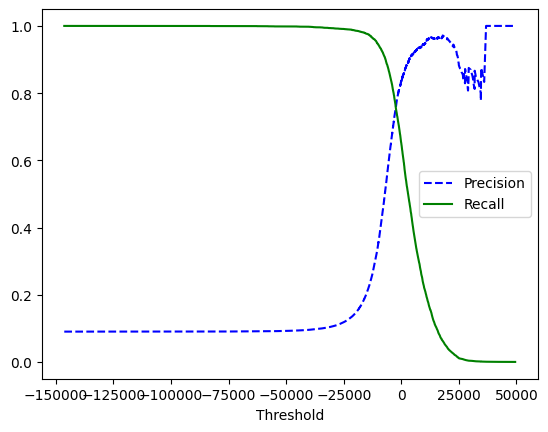

In [26]:

# now we can plot on graph
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") # b-- means blue dashed lines in plot function
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")        # green solid line
    plt.xlabel("Threshold")
    plt.legend(loc="best")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
# Aiming for 90% precision by searching for using np.argmax()
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
y_train_pred_90 = (y_scores >= threshold_90_precision)


In [28]:
# check percision and recall
precision_score(y_train_5, y_train_pred_90)
#90% precision

np.float64(0.9000345901072293)

In [29]:
recall_score(y_train_5, y_train_pred_90)


np.float64(0.4799852425751706)

In [30]:
# RECIVER OPERATING CHARACTERISTIC (ROC) curve
# It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


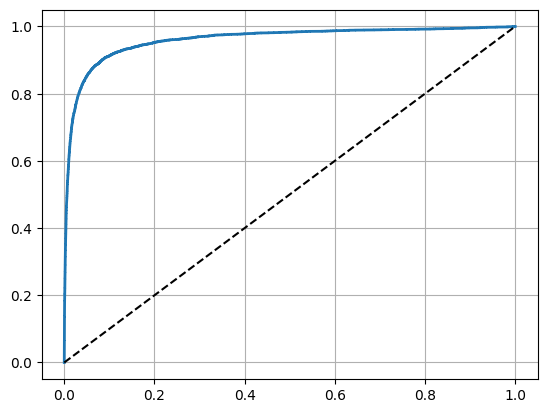

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.grid()
 
plot_roc_curve(fpr, tpr)
plt.show()

# the higher the recall (TPR), the more false positives (FPR) the classifier produces
# The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)


In [32]:
# another way to compare classifiers is to measure AUC (area under curve)
# a perfect classifier will have ROC AUC = 1. Whereas a Purely Random will have a ROC = 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

# Training a `RandomForestClassifier` to Compare `ROC curve` and `ROC AUC score` to the `SGDClassifier`
- First we need to get scores for each instance in training set

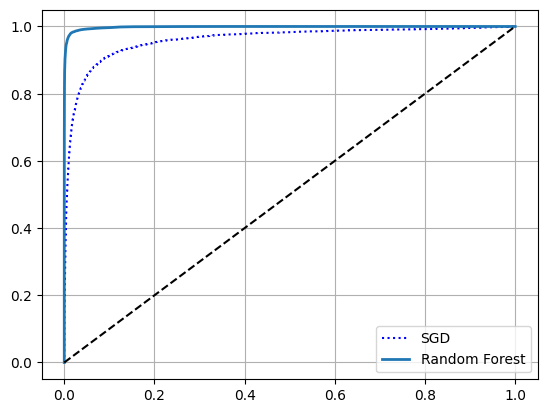

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# Now we plot the ROC curve:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


In [34]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

# Multiclass Classification

- Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.
- Example of Multiclass classifiers include
    - Bayes classifiers, Random forest ...
- Example of Binary classifiers include
    - Support Vefctor Machine classifiers or Linear Classifiers

-  One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

- Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy.
 

In [ ]:
# Automatically Running OvA
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

# This code trains the SGDClassifier on the training set using the original 
# target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes
# (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, 
# Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
# image, and selected the class with the highest score

array([3], dtype=uint8)

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores
# in the output we notice that the highest score is output 3 (counting from 0-9)

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [37]:
np.argmax(some_digit_scores)
# displaying the output with the largest score which is #3 in the array

np.int64(3)

In [38]:
sgd_clf.classes_
# these are the classes in our classification

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [42]:
sgd_clf.classes_[3]

np.uint8(3)

In [ ]:
# Creating a multiclassifier using OvO strategy
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


array([5], dtype=uint8)

In [44]:
len(ovo_clf.estimators_)

45

In [45]:
# training RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
# This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes

array([5], dtype=uint8)

In [46]:
# Getting the list of probabilites that the classifier assigned to each instance for each class
forest_clf.predict_proba([some_digit])
# we see that the classifier is 0.9 (90%) confident the 5th index in the array. 
# its 90% sure that the image stored in some_digit variable represents a 5

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [47]:
# Using cross validation to evaluate these classifications
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# the output shows 87% on all test folds 
# we can scale inputs to get a better value

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# Scaling to acheive a vetter result
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
# our scores have now increased

array([0.8983, 0.891 , 0.9018])

# Error Analysis

Assuming I find a promising model for my project and I want to find ways to improve it. One way to do this is to analyze the types of errors it makes
- first we can look at the `Confusion matrix`
    - First make prediction using `cross_val_predict()`
    - Then call `confusion_matrix()`

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx
# this looks like a lot of numbers to read

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

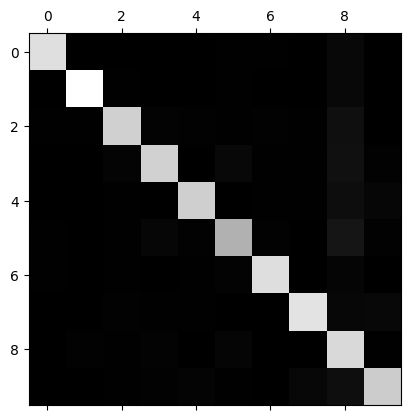

In [51]:
# we represent the number into image representation
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
# this confusion matrix were classified correctly, because images are on the main diagonal


In [52]:
# Let’s focus the plot on the errors. First, you need to divide each value in the confusion
# matrix by the number of images in the corresponding class, so you can compare error
# rates instead of absolute number of errors (which would make abundant classes look unfairly bad):
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

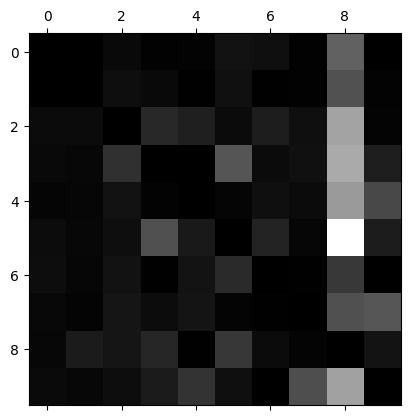

In [53]:
# Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# remember that rows represent the actual classes, and columns represent the predicted classes
# The column for class 8 is quite bright, which tells you that many images get misclassified as 8s
# However, the row for class 8 is not that bad, telling you that actual 8s in general get prop‐ erly classified as 8s.

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s
One way could be to gather more training data for digits that look like 8s so the classifier can learn to distinguish them from real 8s. Or write an algorithm that propaply checks closed loops or some characteristic shape of the number 8





NameError: name 'plot_digits' is not defined

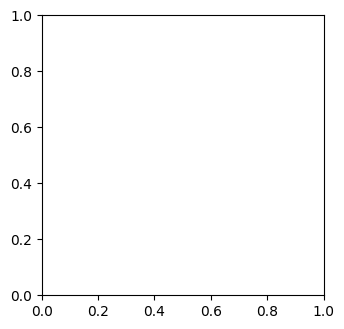

In [54]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


# Multilabel Classification
- Until now each instance has always been assigned to just one class. In some cases may want the classifier to output multiple classes for each instance.
- Lets say we train a model to recognize 3 faces of Tez, Nez, Yez. We show the model the face of Tez & Yez. It should output [1,0,1], (Tez yes, Nez no, Yez yes)
- Such a classification system that outputs multiple binary tags is called a multilabel classification system.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# This code creates a y_multilabel array containing two target labels for each digit
#image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
#indicates whether or not it is odd
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()        # create a KNeighborsClassifier
knn_clf.fit(X_train, y_multilabel)      # train it using the multiple targets array



In [ ]:
knn_clf.predict([some_digit])

In [ ]:
# calc the F1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
